<a href="https://colab.research.google.com/github/kiranraou/Python-Projects/blob/main/Sequence_Learning_End%09Course_CoNLL_2003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 743 kB 9.3 MB/s 


In [6]:
!pip install eli5

     |████████████████████████████████| 106 kB 8.4 MB/s 


In [7]:
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import eli5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [8]:
data = pd.read_csv("/content/drive/MyDrive/NIT Warangal _Industry Project/End Course/GMB_dataset.txt", sep="\t", header=None, encoding="latin1")

In [9]:
#Let us take a sneak-peak into the dataset first
data.head()

,0,1,2,3,4
0,NaN,Sentence #,Word,POS,Tag
1,0.0,1.0,Thousands,NNS,O
2,1.0,1.0,of,IN,O
3,2.0,1.0,demonstrators,NNS,O
4,3.0,1.0,have,VBP,O


In [10]:
#The dataset does not have any header currently. We can use the first row as a header as it has the relevant headings.
#We will make the first row as the heading, remove the first row and re-index the dataset
data.columns = data.iloc[0]
data = data[1:]
data.columns = ['Index','Sentence #','Word','POS','Tag']
data = data.reset_index(drop=True)
data.head()

,Index,Sentence #,Word,POS,Tag
0,0.0,1.0,Thousands,NNS,O
1,1.0,1.0,of,IN,O
2,2.0,1.0,demonstrators,NNS,O
3,3.0,1.0,have,VBP,O
4,4.0,1.0,marched,VBN,O


In [11]:
data.shape

(66161, 5)

In [12]:
#We have 66161 samples and 5 features. We will understand them in detail in the exploration step.
#Lets check for any missing values in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66161 entries, 0 to 66160
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index       66161 non-null  float64
 1   Sentence #  66161 non-null  object 
 2   Word        66161 non-null  object 
 3   POS         66161 non-null  object 
 4   Tag         66161 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.5+ MB


In [13]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [14]:
getter = getsentence(data)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [15]:
#Lets find the number of words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

8766


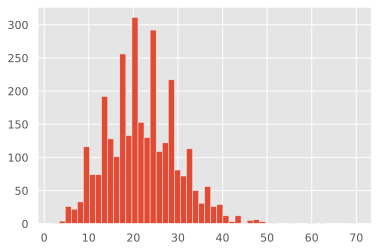

In [16]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [17]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 70


In [18]:
#Words tagged as B-org
data.loc[data['Tag'] == 'B-org', 'Word'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: Word, dtype: object

In [19]:
#Words tagged as I-org
data.loc[data['Tag'] == 'I-org', 'Word'].head()

98      Party
155    Atomic
156    Energy
157    Agency
235     Union
Name: Word, dtype: object

In [20]:
#Words tagged as B-per
data.loc[data['Tag'] == 'B-per', 'Word'].head()

42          Bush
270    President
331       Thomas
443    President
965      Prophet
Name: Word, dtype: object

In [21]:
#Words tagged as I-per
data.loc[data['Tag'] == 'I-per', 'Word'].head()

271        Mahmoud
272    Ahmadinejad
332        Horbach
444      Abdullahi
445          Yusuf
Name: Word, dtype: object

In [22]:
#Words tagged as B-geo
data.loc[data['Tag'] == 'B-geo', 'Word'].head()

6        London
12         Iraq
65         Hyde
94      Britain
106    Brighton
Name: Word, dtype: object

In [23]:
#Words tagged as I-geo
data.loc[data['Tag'] == 'I-geo', 'Word'].head()


66      Park
347    State
350    State
381    Delta
561     Arab
Name: Word, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


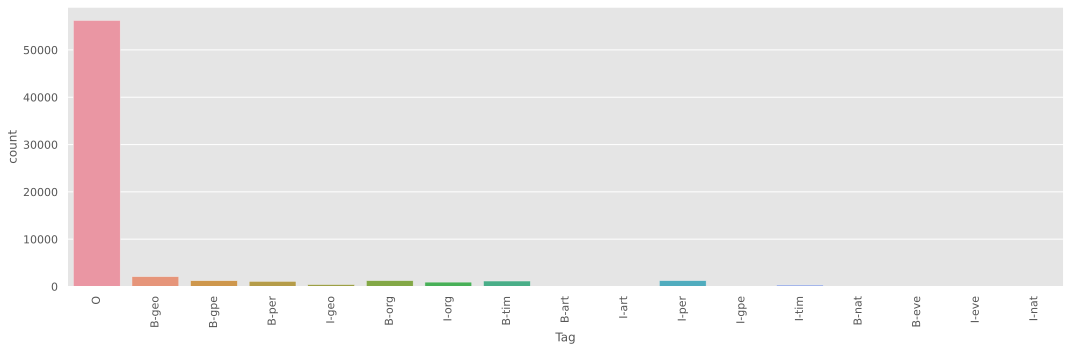

In [24]:
#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


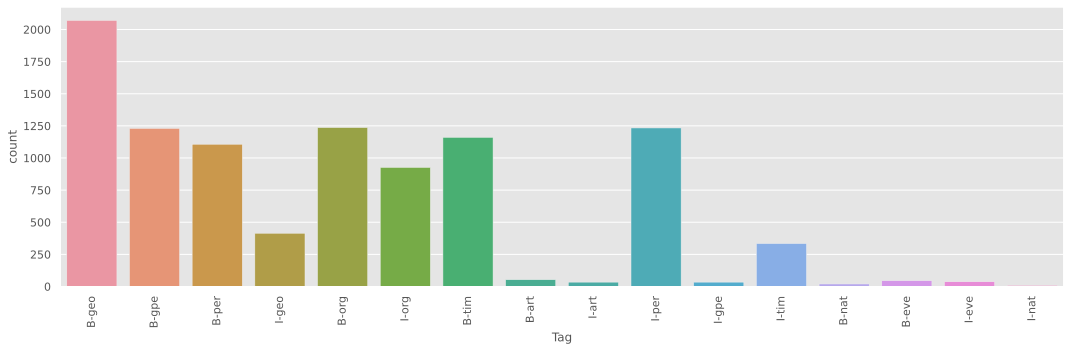

In [25]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


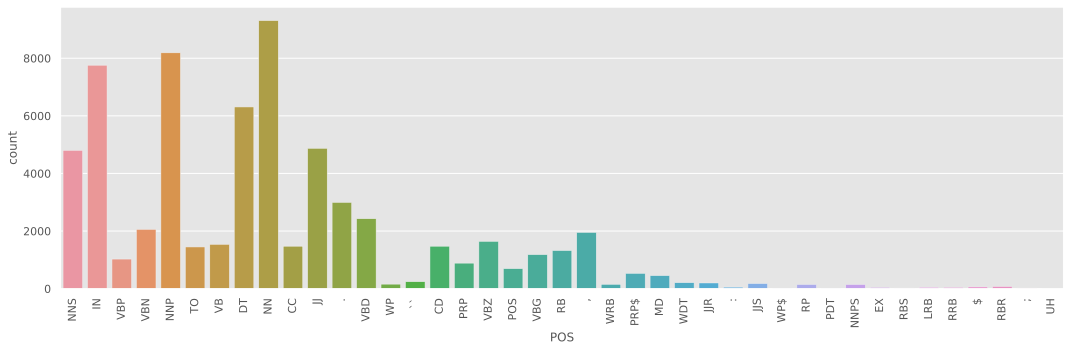

In [26]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot('POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [27]:
##Random Forest classifier
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [28]:
#We divide the dataset into train and test sets
words = [feature_map(w) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()

In [29]:
#Lets see how the input array looks like
print(words[:5])

[array([1, 0, 0, 9, 0, 1]), array([0, 1, 0, 2, 0, 1]), array([ 0,  1,  0, 13,  0,  1]), array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 7, 0, 1])]


In [30]:
#Random Forest classifier
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [31]:
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        53
       B-eve       0.00      0.00      0.00        45
       B-geo       0.23      0.68      0.35      2070
       B-gpe       0.18      0.19      0.19      1230
       B-nat       0.00      0.00      0.00        20
       B-org       0.65      0.15      0.25      1237
       B-per       0.95      0.19      0.31      1107
       B-tim       0.28      0.33      0.31      1160
       I-art       0.00      0.00      0.00        34
       I-eve       0.00      0.00      0.00        37
       I-geo       0.00      0.00      0.00       414
       I-gpe       0.00      0.00      0.00        34
       I-nat       0.00      0.00      0.00         9
       I-org       0.34      0.03      0.05       926
       I-per       0.30      0.01      0.02      1234
       I-tim       0.47      0.05      0.09       334
           O       0.97      0.98      0.98     56217

    accuracy              

**Conditional Random Fields classifier.**

In [32]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [33]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [34]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [35]:
#Creating the CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [36]:
#We predcit using the same 5 fold cross validation
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [37]:
#Lets evaluate the mode
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

              precision    recall  f1-score   support

       B-art       0.14      0.02      0.03        53
       B-eve       0.52      0.27      0.35        45
       B-geo       0.72      0.83      0.77      2070
       B-gpe       0.84      0.75      0.79      1230
       B-nat       0.50      0.20      0.29        20
       B-org       0.67      0.59      0.63      1237
       B-per       0.79      0.77      0.78      1107
       B-tim       0.89      0.81      0.85      1160
       I-art       0.00      0.00      0.00        34
       I-eve       0.53      0.22      0.31        37
       I-geo       0.67      0.62      0.64       414
       I-gpe       0.23      0.09      0.13        34
       I-nat       1.00      0.33      0.50         9
       I-org       0.71      0.71      0.71       926
       I-per       0.81      0.90      0.86      1234
       I-tim       0.75      0.57      0.65       334
           O       0.99      0.99      0.99     56217

    accuracy              

In [38]:
#Tuning the parameters manually, setting c1 = 10
crf2 = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [39]:
pred = cross_val_predict(estimator=crf2, X=X, y=y, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        53
       B-eve       0.00      0.00      0.00        45
       B-geo       0.62      0.86      0.72      2070
       B-gpe       0.85      0.69      0.76      1230
       B-nat       0.00      0.00      0.00        20
       B-org       0.64      0.47      0.54      1237
       B-per       0.74      0.74      0.74      1107
       B-tim       0.93      0.67      0.78      1160
       I-art       0.00      0.00      0.00        34
       I-eve       0.00      0.00      0.00        37
       I-geo       0.60      0.44      0.51       414
       I-gpe       0.00      0.00      0.00        34
       I-nat       0.00      0.00      0.00         9
       I-org       0.62      0.60      0.61       926
       I-per       0.74      0.90      0.81      1234
       I-tim       0.76      0.40      0.52       334
           O       0.99      0.99      0.99     56217

    accuracy              

In [40]:
crf2.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=10, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

**Hyperparameter tuning using Randomized CV Search.**

In [41]:
#First we select all the tags that are relevant for us i.e. remove the 'O' tag from the list. 
labels = list(crf2.classes_)
labels = list(filter(lambda a: a != 'O', labels))
print(labels)

['B-geo', 'B-gpe', 'B-tim', 'B-org', 'I-geo', 'B-per', 'I-per', 'I-org', 'B-nat', 'I-tim', 'I-gpe', 'I-nat', 'B-art', 'I-art', 'B-eve', 'I-eve']


In [42]:
%%time
#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf3 = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 32.2min finished


CPU times: user 20min 33s, sys: 2.93 s, total: 20min 36s
Wall time: 32min 26s


In [43]:
#Lets check the best estimated parameters and CV score
print('Best parameters:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.029224773637917846, 'c2': 0.2533755515897934}
Best CV score: 0.7467309269791563
Model size: 0.98M


In [44]:
#We sort the tags a bit so that they appear in an orderly fashion in the classification report
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))

In [45]:
#Now we create the model again using the best estimators
crf3 = rs.best_estimator_
y_pred = crf3.predict(X)
print(metrics.flat_classification_report(
    y, y_pred, labels=sorted_labels, digits=3))


              precision    recall  f1-score   support

       B-art      0.959     0.887     0.922        53
       I-art      1.000     1.000     1.000        34
       B-eve      0.957     0.978     0.967        45
       I-eve      1.000     0.946     0.972        37
       B-geo      0.878     0.963     0.919      2070
       I-geo      0.913     0.935     0.924       414
       B-gpe      0.951     0.873     0.911      1230
       I-gpe      0.941     0.471     0.627        34
       B-nat      1.000     0.850     0.919        20
       I-nat      1.000     1.000     1.000         9
       B-org      0.953     0.851     0.899      1237
       I-org      0.973     0.973     0.973       926
       B-per      0.971     0.966     0.968      1107
       I-per      0.965     0.990     0.978      1234
       B-tim      0.986     0.928     0.956      1160
       I-tim      0.975     0.937     0.956       334

   micro avg      0.944     0.934     0.939      9944
   macro avg      0.964   

In [46]:
crf3.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.029224773637917846, c2=0.2533755515897934,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [47]:
eli5.show_weights(crf3, top=30)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.775,2.185,0.0,2.239,0.0,2.156,0.0,1.37,0.0,1.014,0.0,2.019,0.0,3.795,0.0,2.709,0.0
B-art,-0.35,0.0,5.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083,0.0
I-art,-1.568,0.0,3.928,0.0,0.0,0.318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.154,0.0
B-eve,-0.718,0.0,0.0,0.0,4.466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124,0.0
I-eve,-0.243,0.0,0.0,0.0,3.177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,0.407,0.867,0.0,0.0,0.0,0.0,7.578,1.286,0.0,0.0,0.0,-0.801,0.0,-0.821,0.0,1.892,0.0
I-geo,-0.176,0.0,0.0,0.0,0.0,0.0,6.269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,0.0
B-gpe,0.759,0.0,0.0,0.0,0.0,-0.202,0.0,0.0,4.806,0.0,0.0,1.714,0.0,1.768,0.0,-1.002,0.0
I-gpe,-0.874,0.0,0.0,0.0,0.0,0.132,0.0,0.0,3.482,0.0,0.0,0.0,0.0,0.178,0.0,0.0,0.0
B-nat,-0.611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.515,0.0,0.0,0.0,0.0,0.0,0.0
